In [1]:
## Import all packages
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup, NavigableString
from urllib.request import urlopen
import os, re
import numpy as np
import pubchempy as pcp
import pandas as pd
from tqdm import tqdm
from rdkit import Chem

from mordred import Calculator, descriptors
trainingSetDF = pd.read_excel("DrugInformation_ImmuneModPaper.xlsx")
###Drop duplicates (certain drugs listed multiple times with slightly different smiles)
trainingSetDF = trainingSetDF.drop_duplicates(subset = "CHEMBL_ID")
##Remove compounds without ChEMBL IDs
trainingSetDF = trainingSetDF[~pd.isna(trainingSetDF.CHEMBL_ID)]
##Using sturcture links_1 because chembl_ID was written differently.
drugBankDF = pd.read_csv("structure links_1.csv")
##Remove compounds without ChEMBL IDs
drugBankDF = drugBankDF[~pd.isna(drugBankDF.CHEMBL_ID)]
##How many drugs overlap between the training set and drugbank?
overlap = len(set(trainingSetDF.CHEMBL_ID.unique()).intersection(set(drugBankDF.CHEMBL_ID.unique())))
print(overlap)
##Merge
combinedDF = pd.merge(trainingSetDF, drugBankDF, on= "CHEMBL_ID", how = "inner")
assert combinedDF.shape[0] == overlap

747


In [2]:
## molecular calculator
calc = Calculator(descriptors, ignore_3D = True)

In [3]:
#combinedDF['SMILES_x']

In [3]:
def m_calculator(dataframe):
    calc = Calculator(descriptors, ignore_3D = True)
    mols = [Chem.MolFromSmiles(smi) for smi in dataframe['SMILES_x']]
    calDF = calc.pandas(mols)
    return (calDF)

In [4]:
# use SMILES to calculate 
mols = [Chem.MolFromSmiles(smi) for smi in combinedDF['SMILES_x']]
## Create a dataframe after calculation
calDF = calc.pandas(mols)

 28%|██▊       | 208/747 [00:29<01:53,  4.74it/s]

/Users/eric/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 30%|██▉       | 223/747 [00:31<02:48,  3.11it/s]

/Users/eric/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 41%|████      | 308/747 [00:44<02:10,  3.35it/s]

/Users/eric/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 747/747 [01:44<00:00,  7.18it/s]


In [5]:
## Adding CHEMBL_ID as index
calDF = calDF.set_index(x for x in combinedDF['CHEMBL_ID'])

In [6]:
calDF.shape

(747, 1613)

In [7]:
## Change data types to float
calDFFloat = pd.DataFrame(calDF, dtype='float')

In [8]:
calDFFloat.shape

(747, 1613)

In [9]:
## Drop columns with more than 5% missing values.
calDF_test = calDFFloat[calDFFloat.columns[calDFFloat.isnull().mean() < .05]]
calDF_test.shape

(747, 1392)

In [10]:
## Check how many columns have 0 std.
std_vals = calDF_test.std()

In [11]:
count = 0
for i in std_vals:
    
    if i == 0:
        count += 1
print(count)

134


In [13]:
## Remove std = 0 columns
calDF_ST = calDF_test[calDF_test.columns[calDF_test.std() != 0]]

In [14]:
calDF_ST.shape

(747, 1258)

In [15]:
## insert a column with CHEMBL_ID 
calDF_ST.insert(0,"CHEMBL_ID",[x for x in combinedDF['CHEMBL_ID']])

In [16]:
calDF_ST.head()

,CHEMBL_ID,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
CHEMBL222280,CHEMBL222280,13.003721,11.805899,0.0,0.0,21.163013,2.430127,4.790842,21.163013,1.244883,...,9.743730,63.794961,305.985134,10.928040,505.0,26.0,88.0,104.0,7.027778,3.777778
CHEMBL844,CHEMBL844,13.423098,11.209659,0.0,3.0,22.818993,2.412409,4.818966,22.818993,1.342294,...,9.736193,63.007560,291.011957,10.778221,515.0,24.0,90.0,106.0,4.305556,3.750000
CHEMBL388590,CHEMBL388590,17.125041,14.795147,0.0,0.0,28.373722,2.499388,4.899958,28.373722,1.289715,...,10.136938,70.803080,421.915318,12.409274,988.0,38.0,118.0,143.0,8.000000,4.861111
CHEMBL1201287,CHEMBL1201287,14.389425,12.216867,0.0,1.0,24.221083,2.349628,4.699256,24.221083,1.274794,...,9.572271,51.676805,318.073161,8.370346,718.0,25.0,92.0,103.0,6.305556,4.305556
CHEMBL1199080,CHEMBL1199080,9.579175,9.100648,0.0,1.0,15.610374,2.304315,4.608630,15.610374,1.200798,...,9.256938,43.893749,242.053888,8.068463,248.0,16.0,62.0,68.0,5.784722,2.944444


In [17]:
## create one dataframe by merging initial database with mol calculation dataframe on CHEMBL_ID
combinedDFF = pd.merge(combinedDF, calDF_ST, on= "CHEMBL_ID", how = "inner")

In [18]:
combinedDFF.head()

,SMILES_x,CHEMSPIDER_ID,CHEMBL_ID,CHEMBL_KNOWN_DRUG,CHEMBL_NAME,CHEMBL_ALTERNATE_NAME,CLINICALTRIALS_DB,CONCENTRATION_uM,DrugBank ID,Name,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,BrC1=CN([C@@H]2O[C@H](CO)[C@@H](O)C2)C(=O)NC1=O,5813.0,CHEMBL222280,No,BROXURIDINE,SID50105447|SID17389223|SID90341500|SID5646351...,1,10,DB12028,Broxuridine,...,9.743730,63.794961,305.985134,10.928040,505.0,26.0,88.0,104.0,7.027778,3.777778
1,Brc1c2nccnc2ccc1NC=1NCCN=1,2341.0,CHEMBL844,Yes,BRIMONIDINE,Alphagan|Brimonidine|UK-14304|Alphagan-P|SID10...,256,10,DB00484,Brimonidine,...,9.736193,63.007560,291.011957,10.778221,515.0,24.0,90.0,106.0,4.305556,3.750000
2,Brc1cc(cc(Br)c1O)C(=O)c1c2c(oc1CC)cccc2,2243.0,CHEMBL388590,No,BENZBROMARONE,SID11110651|SID26664708|SID24424558|SID5010399...,2,10,DB12319,Benzbromarone,...,10.136938,70.803080,421.915318,12.409274,988.0,38.0,118.0,143.0,8.000000,4.861111
3,Brc1ccc(cc1)[C@H](CCN(C)C)c1ncccc1,16068.0,CHEMBL1201287,Yes,DEXBROMPHENIRAMINE,SID90341837|Dexbrompheniramine|SID29216402|,0,10,DB00405,Dexbrompheniramine,...,9.572271,51.676805,318.073161,8.370346,718.0,25.0,92.0,103.0,6.305556,4.305556
4,Brc1ccccc1C[N+](CC)(C)C,2337.0,CHEMBL1199080,Yes,BRETYLIUM,SID50113155|Bretylium|SID50113154|,0,17,DB01158,Bretylium,...,9.256938,43.893749,242.053888,8.068463,248.0,16.0,62.0,68.0,5.784722,2.944444


In [19]:
def retrieveBioassayInfo(cid):
    aid = []
    score = []
    gene = []
    act = []
    try:
        page = urlopen('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+cid +'/assaysummary/XML')
        soup = BeautifulSoup(page, "html.parser")
        colNames = soup.find("columns").find_all("column")
        aidIndex = -1
        activityIndex = -1
        for i, col in enumerate(colNames):
            if col.text == "AID":
                aidIndex = i
            elif col.text == "Activity Value [uM]":
                scoreIndex = i
            elif col.text == "Bioactivity Outcome":
                activityIndex = i
            elif col.text == "Target GeneID":
                geneIndex = i
        for row in soup.find_all("row"):
            values= row.find_all("cell")
            if values[geneIndex].text !=  '':
                score.append(values[scoreIndex].text)
                gene.append(values[geneIndex].text)
                aid.append(values[aidIndex].text)
                act.append(values[activityIndex].text)
    except Exception as e: 
        pass
    return(aid, act, gene, score)

In [20]:
def collectDrugActiveTar(cid):
    (aid, act, gene, score) = retrieveBioassayInfo(cid)
    activeIndices = [i for i, x in enumerate(act) if x == "Active"]
    cidList = [cid]*len(activeIndices)
    df = pd.DataFrame({'cid':cidList,
                   'aid':[x for i, x in enumerate(aid) if i in activeIndices],
                    'score':[x for i, x in enumerate(score) if i in activeIndices], 
                    'entrezID':[x for i, x in enumerate(gene) if i in activeIndices]})
    return(df)

In [21]:
def createFullTargetDF(drugData):
    """
    This method creates a full df with all pubchem targets
    :param: a drug data frame with one column listed with a drug's cid and a second with drug id
    :return: data frame with all bioassay target information
    """
    fullTargetDF = pd.DataFrame(columns=['cid','aid','score',
                                         'entrezID', "drug_id"])
    for i, row in tqdm(drugData.iterrows(), total=drugData.shape[0]):
        ##Collect drug targets 
        pubChemDF = collectDrugActiveTar(row["PubCHEM"])
        
        ##get drug id information
        nameDF = pd.DataFrame({"drug_id": [row["drug_id"]]*pubChemDF.shape[0]})
        
        ##combine all drug information
        drugDF = pd.concat([pubChemDF,nameDF],axis=1)
        
        fullTargetDF = pd.concat([fullTargetDF, drugDF])
    ##write out
    return(fullTargetDF)

In [22]:
# Get CID and drugname from combined DF
cid_drug = combinedDF[['PubChem Compound ID','Name']]

In [23]:
cid_drug = cid_drug.rename(columns={"PubChem Compound ID": "PubCHEM", "Name": "drug_id"})

In [29]:
## checking data types for each columns
cid_drug.info()
cid_drug = cid_drug.astype(str)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747 entries, 0 to 746
Data columns (total 2 columns):
PubCHEM    747 non-null object
drug_id    747 non-null object
dtypes: object(2)
memory usage: 17.5+ KB


In [28]:
## drop columns with missing PubChemCompund ID
cid_drug = cid_drug.dropna()
cid_drug.shape
cid_drug.astype(str)
## change it to integer to remove decimal points
cid_drug = cid_drug.astype({"PubCHEM": int, "drug_id": object})
cid_drug.info()
## change it to string type to use it on created function
cid_drug.astype(str)

ValueError: invalid literal for int() with base 10: '6035.0'

In [84]:
createFullTargetDF(cid_drug)

100%|██████████| 720/720 [27:21<00:00,  1.84s/it]


,cid,aid,score,entrezID,drug_id
0,6035,1458,14.1254,6607,Broxuridine
1,6035,1458,10,6607,Broxuridine
2,6035,1471,,3064,Broxuridine
3,6035,210689,5.06,7083,Broxuridine
4,6035,210691,25,7083,Broxuridine
5,6035,408386,5,888740,Broxuridine
6,6035,624032,4.0533,24660,Broxuridine
7,6035,624044,7.9373,24660,Broxuridine
8,6035,651751,39.8107,84385,Broxuridine
9,6035,651758,53.0804,3576,Broxuridine


In [30]:
##Make a data frame with one column called "PubCHEM" and other named "drug_id"
cid = {'PubCHEM': [x for x in combinedDF['PubChem Compound ID']], 'drug_id': [y for y in combinedDF['Name']]}
drug = pd.DataFrame(data=cid)


In [31]:
## same as before with less lines
drug = drug.dropna()

In [32]:
drug = drug.astype({"PubCHEM": int, "drug_id": object})

In [33]:
drug = drug.astype(str)

In [35]:
fullTargetDF=createFullTargetDF(drug)

100%|██████████| 720/720 [28:42<00:00,  1.64s/it] 


In [36]:
fullTargetDF.head()

,cid,aid,score,entrezID,drug_id
0,6035,1458,14.1254,6607,Broxuridine
1,6035,1458,10,6607,Broxuridine
2,6035,1471,,3064,Broxuridine
3,6035,210689,5.06,7083,Broxuridine
4,6035,210691,25,7083,Broxuridine


In [37]:
## Load packages for model building
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers


In [38]:
## load dataframe with immunomodulatory effect scores
imscore = pd.read_excel("ImmunModPotential_Supp2.xlsx")

In [39]:
## column name didn't match from ImmunModPotential dataframe to our existing dataframe
imscore = imscore.rename(columns = {'name':"Name"})

In [40]:
## drug name didn't follow the same patter so change it to Capital letter + lower case and dropped null values
imscore.Name = imscore.Name.str.title()
imscore = imscore.dropna()

In [42]:
imscore.head()

,Name,VSV Infection,CD11C-CD11C,CD11C-CD14,CD11C-CD3,CD14-CD11C,CD14-CD14,CD14-CD19,CD19-CD14,CD19-CD19,CD19-CD3,CD3-CD11C,CD3-CD19,CD3-CD3
0,Bretylium Tosylate,0.281753,0.550864,0.074751,0.014859,0.290010,0.409782,0.560029,-0.402144,0.436481,-0.289821,-0.664059,0.232299,1.633227
1,Etomidate,0.292824,-0.965403,-1.736563,-0.367279,-0.124403,-0.993170,-0.206141,-0.192112,0.394961,-0.202929,-0.268586,-0.211872,-0.261213
2,Loperamide,-0.117341,-1.235752,0.227102,-0.182275,-0.985964,-0.438482,-0.509173,-0.592557,0.147891,-0.247796,0.067999,-0.998143,-0.166568
3,Chlorambucil,0.073640,0.088478,1.371637,-0.254888,0.778015,0.836844,-0.184801,-0.547305,-0.826591,-0.292145,-0.789511,-0.552819,-0.480118
4,Carmustine,-0.006240,-0.378749,0.125306,0.018359,-0.403721,-0.216324,-1.950322,-0.763955,-1.176017,-0.310338,0.386267,-0.270848,-0.251057


In [43]:
combinedDFF.Name = combinedDFF.Name.str.title()

In [44]:
## create a dataframe merging first dataframe(dataframe with mol calculation) with immunomodulatory potential score table by drug name
matrix = pd.merge(combinedDFF, imscore, on = "Name", how = "inner")

In [45]:
matrix.shape

(516, 1295)

In [50]:
## check columns with mol.cal calculation
matrix.iloc[:,24:1283].head()

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,VSV Infection
0,13.003721,11.805899,0.0,0.0,21.163013,2.430127,4.790842,21.163013,1.244883,3.759503,...,63.794961,305.985134,10.928040,505.0,26.0,88.0,104.0,7.027778,3.777778,0.073620
1,14.389425,12.216867,0.0,1.0,24.221083,2.349628,4.699256,24.221083,1.274794,3.848879,...,51.676805,318.073161,8.370346,718.0,25.0,92.0,103.0,6.305556,4.305556,0.494825
2,23.598392,18.449570,0.0,1.0,39.093833,2.428055,4.836608,39.093833,1.303128,4.336994,...,79.445461,449.118544,8.636895,2633.0,49.0,160.0,190.0,9.722222,6.527778,-3.540953
3,23.598392,18.449570,0.0,1.0,39.093833,2.428055,4.836608,39.093833,1.303128,4.336994,...,79.445461,449.118544,8.636895,2633.0,49.0,160.0,190.0,9.722222,6.527778,-2.175290
4,26.472550,20.542158,0.0,1.0,44.176297,2.515749,5.031498,44.176297,1.299303,4.454465,...,70.685296,476.223056,7.107807,3458.0,60.0,180.0,215.0,10.902778,7.486111,-0.117341


In [139]:
## For training datasets use columns containing molecular calculation columns
X = matrix.iloc[:,24:1283].values

In [140]:
## Check column position to be used as a label
matrix.iloc[:,1283:1284].head()

,CD11C-CD11C
0,0.460685
1,0.777075
2,2.043278
3,0.151665
4,-1.235752


In [141]:
## For label datasets use one column with CD11 - CD11 interaction column
Y = matrix.iloc[:,1283:1284]

In [142]:
## Create an artificial label based on score range. A = increasing immunesystem activity, B = low/no effect, C = decreasing immunesystem activity, U = unknown 
result = []
for i in Y['CD11C-CD11C']:
    if i > 1.7:
        result.append("A")
    else:
        result.append("B")

print(len(result))

516


In [143]:
## add a column called "Label" with artificial labels created
Y.insert(loc=1, column='Label', value=result)

In [144]:
## Only get the values without the column name to use it as labeling set
Y = Y["Label"].values

In [145]:
## Change artificial label created with encoder changing letters into numbers ("A" = 0, "B" = 1, "C" = 2)
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
encoded_Y.shape

(516,)

In [146]:
## Set training datasets with label sets 
X_train, X_test, y_train, y_test = train_test_split(X, encoded_Y, test_size = 0.2)

In [147]:
import numpy.ma as ma

X_train = np.where(np.isnan(X_train), ma.array(X_train, mask=np.isnan(X_train)).mean(axis=0), X_train)
X_test = np.where(np.isnan(X_test), ma.array(X_test, mask=np.isnan(X_test)).mean(axis=0), X_test)

In [148]:
model = Sequential()
model.add(Dense(100, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(60, activation='relu'))
model.add(Dense(70, activation='relu'))
model.add(Dense(1, activation ='sigmoid'))

In [151]:
keras.optimizers.Adam(learning_rate=0.000000000001, beta_1=0.9, beta_2=0.999, amsgrad=False)

In [152]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [153]:
model.fit(X_train, y_train, epochs=1000, batch_size = 50)

Epoch 1/1000
412/412 [==============================] - 0s 746us/sample - loss: 44.6364 - acc: 0.8422
Epoch 2/1000
412/412 [==============================] - 0s 120us/sample - loss: 17.4891 - acc: 0.9029
Epoch 3/1000
412/412 [==============================] - 0s 122us/sample - loss: 7.7358 - acc: 0.8908
Epoch 4/1000
412/412 [==============================] - 0s 130us/sample - loss: 4.7117 - acc: 0.8738
Epoch 5/1000
412/412 [==============================] - 0s 118us/sample - loss: 3.5467 - acc: 0.9053
Epoch 6/1000
412/412 [==============================] - 0s 126us/sample - loss: 3.5875 - acc: 0.8641
Epoch 7/1000
412/412 [==============================] - 0s 108us/sample - loss: 7.8829 - acc: 0.9466
Epoch 8/1000
412/412 [==============================] - 0s 107us/sample - loss: 5.4010 - acc: 0.8374
Epoch 9/1000
412/412 [==============================] - 0s 107us/sample - loss: 2.7901 - acc: 0.8786
Epoch 10/1000
412/412 [==============================] - 0s 127us/sample - loss: 3.8291 -

412/412 [==============================] - 0s 125us/sample - loss: 0.2078 - acc: 0.9417
Epoch 161/1000
412/412 [==============================] - 0s 136us/sample - loss: 0.2481 - acc: 0.9393
Epoch 162/1000
412/412 [==============================] - 0s 112us/sample - loss: 0.1556 - acc: 0.9539
Epoch 163/1000
412/412 [==============================] - 0s 105us/sample - loss: 0.1579 - acc: 0.9490
Epoch 164/1000
412/412 [==============================] - 0s 125us/sample - loss: 0.1914 - acc: 0.9442
Epoch 165/1000
412/412 [==============================] - ETA: 0s - loss: 0.1547 - acc: 0.940 - 0s 110us/sample - loss: 0.1897 - acc: 0.9417
Epoch 166/1000
412/412 [==============================] - 0s 118us/sample - loss: 0.1478 - acc: 0.9490
Epoch 167/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1625 - acc: 0.9466
Epoch 168/1000
412/412 [==============================] - 0s 116us/sample - loss: 0.1224 - acc: 0.9515
Epoch 169/1000
412/412 [===========================

412/412 [==============================] - 0s 99us/sample - loss: 0.0981 - acc: 0.9587
Epoch 320/1000
412/412 [==============================] - 0s 93us/sample - loss: 0.1065 - acc: 0.9612
Epoch 321/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.1032 - acc: 0.9636
Epoch 322/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1559 - acc: 0.9490
Epoch 323/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.1583 - acc: 0.9515
Epoch 324/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.1845 - acc: 0.9442
Epoch 325/1000
412/412 [==============================] - 0s 96us/sample - loss: 0.1284 - acc: 0.9587
Epoch 326/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.1062 - acc: 0.9563
Epoch 327/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.1258 - acc: 0.9466
Epoch 328/1000
412/412 [==============================] - 0s 93us/sample - loss: 0.1172 - ac

412/412 [==============================] - 0s 105us/sample - loss: 0.1400 - acc: 0.9442
Epoch 400/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1485 - acc: 0.9466
Epoch 401/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.2277 - acc: 0.9248
Epoch 402/1000
412/412 [==============================] - 0s 107us/sample - loss: 0.1553 - acc: 0.9490
Epoch 403/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1575 - acc: 0.9539
Epoch 404/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1268 - acc: 0.9539
Epoch 405/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.1335 - acc: 0.9515
Epoch 406/1000
412/412 [==============================] - 0s 97us/sample - loss: 0.1828 - acc: 0.9515
Epoch 407/1000
412/412 [==============================] - 0s 97us/sample - loss: 0.2345 - acc: 0.9417
Epoch 408/1000
412/412 [==============================] - 0s 104us/sample - loss: 0.2275 - ac

412/412 [==============================] - 0s 110us/sample - loss: 0.1254 - acc: 0.9515
Epoch 558/1000
412/412 [==============================] - 0s 96us/sample - loss: 0.1074 - acc: 0.9563
Epoch 559/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.0855 - acc: 0.9612
Epoch 560/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.0818 - acc: 0.9612
Epoch 561/1000
412/412 [==============================] - 0s 91us/sample - loss: 0.0929 - acc: 0.9563
Epoch 562/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.0844 - acc: 0.9563
Epoch 563/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.1669 - acc: 0.9515
Epoch 564/1000
412/412 [==============================] - 0s 96us/sample - loss: 0.1221 - acc: 0.9636
Epoch 565/1000
412/412 [==============================] - 0s 94us/sample - loss: 0.1199 - acc: 0.9393
Epoch 566/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1065 - acc

412/412 [==============================] - 0s 100us/sample - loss: 0.0875 - acc: 0.9466
Epoch 718/1000
412/412 [==============================] - 0s 94us/sample - loss: 0.0980 - acc: 0.9466
Epoch 719/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1436 - acc: 0.9466
Epoch 720/1000
412/412 [==============================] - 0s 94us/sample - loss: 0.1086 - acc: 0.9466
Epoch 721/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.1213 - acc: 0.9466
Epoch 722/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.1445 - acc: 0.9466
Epoch 723/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1771 - acc: 0.9466
Epoch 724/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1288 - acc: 0.9466
Epoch 725/1000
412/412 [==============================] - 0s 102us/sample - loss: 0.1054 - acc: 0.9466
Epoch 726/1000
412/412 [==============================] - 0s 95us/sample - loss: 0.1025 - acc

412/412 [==============================] - 0s 98us/sample - loss: 0.0834 - acc: 0.9709
Epoch 798/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.1171 - acc: 0.9248
Epoch 799/1000
412/412 [==============================] - 0s 95us/sample - loss: 0.1502 - acc: 0.9587
Epoch 800/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1115 - acc: 0.9612
Epoch 801/1000
412/412 [==============================] - 0s 103us/sample - loss: 0.0831 - acc: 0.9660
Epoch 802/1000
412/412 [==============================] - 0s 97us/sample - loss: 0.1578 - acc: 0.9053
Epoch 803/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1701 - acc: 0.8519
Epoch 804/1000
412/412 [==============================] - 0s 94us/sample - loss: 0.1462 - acc: 0.8762
Epoch 805/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.1406 - acc: 0.9466
Epoch 806/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.1695 - acc

412/412 [==============================] - 0s 98us/sample - loss: 0.1504 - acc: 0.9466
Epoch 878/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.1046 - acc: 0.9466
Epoch 879/1000
412/412 [==============================] - 0s 93us/sample - loss: 0.1504 - acc: 0.9466
Epoch 880/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1271 - acc: 0.9466
Epoch 881/1000
412/412 [==============================] - 0s 97us/sample - loss: 0.1680 - acc: 0.9466
Epoch 882/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1467 - acc: 0.9466
Epoch 883/1000
412/412 [==============================] - 0s 106us/sample - loss: 0.1640 - acc: 0.9466
Epoch 884/1000
412/412 [==============================] - 0s 92us/sample - loss: 0.1601 - acc: 0.9466
Epoch 885/1000
412/412 [==============================] - 0s 98us/sample - loss: 0.1291 - acc: 0.9466
Epoch 886/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.1727 - acc: 

412/412 [==============================] - 0s 101us/sample - loss: 0.1116 - acc: 0.9515
Epoch 958/1000
412/412 [==============================] - 0s 107us/sample - loss: 0.1234 - acc: 0.9515
Epoch 959/1000
412/412 [==============================] - 0s 95us/sample - loss: 0.1016 - acc: 0.9515
Epoch 960/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.0845 - acc: 0.9515
Epoch 961/1000
412/412 [==============================] - 0s 101us/sample - loss: 0.0831 - acc: 0.9515
Epoch 962/1000
412/412 [==============================] - 0s 95us/sample - loss: 0.0722 - acc: 0.9515
Epoch 963/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.0827 - acc: 0.9515
Epoch 964/1000
412/412 [==============================] - 0s 99us/sample - loss: 0.0905 - acc: 0.9515
Epoch 965/1000
412/412 [==============================] - 0s 100us/sample - loss: 0.0826 - acc: 0.9515
Epoch 966/1000
412/412 [==============================] - 0s 102us/sample - loss: 0.1016 - 

In [154]:
_, accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))

104/104 [==============================] - 0s 852us/sample - loss: 0.2081 - acc: 0.9808
Accuracy: 98.08


In [155]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             multiple                  126000    
_________________________________________________________________
dense_25 (Dense)             multiple                  6060      
_________________________________________________________________
dense_26 (Dense)             multiple                  4880      
_________________________________________________________________
dense_27 (Dense)             multiple                  4860      
_________________________________________________________________
dense_28 (Dense)             multiple                  4270      
_________________________________________________________________
dense_29 (Dense)             multiple                  71        
Total params: 146,141
Trainable params: 146,141
Non-trainable params: 0
________________________________________________

In [156]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
y_pred = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [157]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [158]:
print(auc_keras)


0.6323529411764706


In [168]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=5, n_estimators=20)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [169]:
y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred)
auc_rf = auc(fpr_rf, tpr_rf)

In [170]:
import matplotlib.pyplot as plt

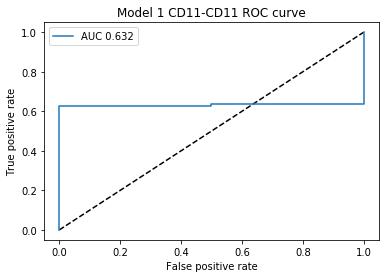

In [171]:

A = plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_rf, tpr_rf, label='AUC {:.3f}'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model 1 CD11-CD11 ROC curve')
plt.legend(loc='best')
plt.show()

A.savefig("CD11-CD11.pdf", bbox_inches='tight')

Score:  -78.02195607141961
Weights:  [ 0.00696367  0.12016697 -0.30604485 ... -0.01665737 -0.02219906
  0.1258164 ]


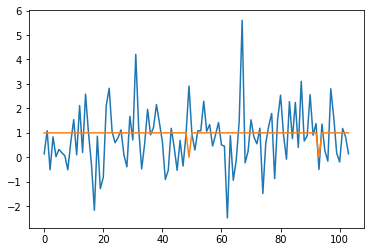

In [172]:
from sklearn.linear_model import LinearRegression

lineReg = LinearRegression()
lineReg.fit(X_train, y_train)
print('Score: ', lineReg.score(X_test, y_test))
print('Weights: ', lineReg.coef_)

plt.plot(lineReg.predict(X_test))
plt.plot(y_test)
plt.show()

In [86]:
#from sklearn.metrics import confusion_matrix
#predicted = model.predict(X_test)
#matrix2 = confusion_matrix(y_test, predicted)
#print(matrix2)

In [178]:
## CD 11-CD 14 model
X1 = matrix.iloc[:,24:1283].values
Y1 = matrix.iloc[:,1284:1285]
result1 = []
for i in Y1['CD11C-CD14']:
    if i > 1.5:
        result1.append("A")
    else:
        result1.append("B")

print(len(result1))
Y1.insert(loc=1, column='Label', value=result1)
Y1 = Y1["Label"].values
encoder.fit(Y1)
encoded_Y1 = encoder.transform(Y1)
encoded_Y1.shape
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, encoded_Y1, test_size = 0.2)
import numpy.ma as ma

X1_train = np.where(np.isnan(X1_train), ma.array(X1_train, mask=np.isnan(X1_train)).mean(axis=0), X1_train)
X1_test = np.where(np.isnan(X1_test), ma.array(X1_test, mask=np.isnan(X1_test)).mean(axis=0), X1_test)
model1 = Sequential()
model1.add(Dense(100, activation='relu'))
model1.add(Dense(60, activation='relu'))
model1.add(Dense(80, activation='relu'))
model1.add(Dense(60, activation='relu'))
model1.add(Dense(70, activation='relu'))
model1.add(Dense(1, activation ='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model1.fit(X1_train, y1_train, epochs=200, batch_size = 20)
rf1 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf1.fit(X1_train, y1_train)
y1_pred_rf = rf1.predict_proba(X1_test)[:, 1]
fpr1_rf, tpr1_rf, thresholds1_rf = roc_curve(y1_test, y1_pred_rf)



516
Epoch 1/200
412/412 [==============================] - 0s 826us/sample - loss: 1374240.8398 - acc: 0.8155
Epoch 2/200
412/412 [==============================] - 0s 205us/sample - loss: 8.6068 - acc: 0.8811
Epoch 3/200
412/412 [==============================] - 0s 206us/sample - loss: 3.2496 - acc: 0.9005
Epoch 4/200
412/412 [==============================] - 0s 199us/sample - loss: 3.6067 - acc: 0.8835
Epoch 5/200
412/412 [==============================] - 0s 200us/sample - loss: 4.5844 - acc: 0.9150
Epoch 6/200
412/412 [==============================] - 0s 219us/sample - loss: 2.5060 - acc: 0.8908
Epoch 7/200
412/412 [==============================] - 0s 195us/sample - loss: 2.3079 - acc: 0.9005
Epoch 8/200
412/412 [==============================] - 0s 185us/sample - loss: 2.1042 - acc: 0.9005
Epoch 9/200
412/412 [==============================] - 0s 195us/sample - loss: 6.0212 - acc: 0.9126
Epoch 10/200
412/412 [==============================] - 0s 199us/sample - loss: 3.3774 - a

412/412 [==============================] - 0s 199us/sample - loss: 0.2060 - acc: 0.9417
Epoch 83/200
412/412 [==============================] - 0s 188us/sample - loss: 0.2320 - acc: 0.9393
Epoch 84/200
412/412 [==============================] - 0s 197us/sample - loss: 0.2541 - acc: 0.9417
Epoch 85/200
412/412 [==============================] - 0s 180us/sample - loss: 0.2011 - acc: 0.9442
Epoch 86/200
412/412 [==============================] - 0s 188us/sample - loss: 0.2043 - acc: 0.9442
Epoch 87/200
412/412 [==============================] - 0s 194us/sample - loss: 0.2981 - acc: 0.9296
Epoch 88/200
412/412 [==============================] - 0s 187us/sample - loss: 0.2118 - acc: 0.9442
Epoch 89/200
412/412 [==============================] - 0s 191us/sample - loss: 0.2029 - acc: 0.9345
Epoch 90/200
412/412 [==============================] - 0s 180us/sample - loss: 0.2189 - acc: 0.9345
Epoch 91/200
412/412 [==============================] - 0s 194us/sample - loss: 0.3207 - acc: 0.9345
Epo

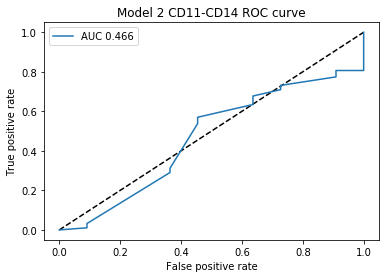

In [179]:
auc1_rf = auc(fpr1_rf, tpr1_rf)
B = plt.figure(2)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr1_rf, tpr1_rf, label='AUC {:.3f}'.format(auc1_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model 2 CD11-CD14 ROC curve')
plt.legend(loc='best')
plt.show()

B.savefig("CD14-CD11.pdf", bbox_inches='tight')


In [180]:
## CD 11-CD 14 model
X2 = matrix.iloc[:,24:1283].values
Y2 = matrix.iloc[:,1285:1286]
result2 = []
for i in Y2['CD11C-CD3']:
    if i > 1.5:
        result2.append("A")
    else:
        result2.append("B")

print(len(result2))
Y2.insert(loc=1, column='Label', value=result2)
Y2 = Y2["Label"].values
encoder.fit(Y2)
encoded_Y2 = encoder.transform(Y2)
encoded_Y2.shape
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, encoded_Y2, test_size = 0.2)
import numpy.ma as ma

X2_train = np.where(np.isnan(X2_train), ma.array(X2_train, mask=np.isnan(X2_train)).mean(axis=0), X2_train)
X2_test = np.where(np.isnan(X2_test), ma.array(X2_test, mask=np.isnan(X2_test)).mean(axis=0), X2_test)
model2 = Sequential()
model2.add(Dense(100, activation='relu'))
model2.add(Dense(60, activation='relu'))
model2.add(Dense(80, activation='relu'))
model2.add(Dense(60, activation='relu'))
model2.add(Dense(70, activation='relu'))
model2.add(Dense(1, activation ='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model2.fit(X2_train, y2_train, epochs=200, batch_size = 20)
y2_pred = model2.predict(X2_test).ravel()
fpr2_keras, tpr2_keras, thresholds2_keras = roc_curve(y2_test, y2_pred)
auc2_keras = auc(fpr2_keras, tpr2_keras)
rf2 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf2.fit(X2_train, y2_train)
y2_pred_rf = rf2.predict_proba(X2_test)[:, 1]
fpr2_rf, tpr2_rf, thresholds2_rf = roc_curve(y2_test, y2_pred)
auc2_rf = auc(fpr2_rf, tpr2_rf)



516
Epoch 1/200
412/412 [==============================] - 0s 1ms/sample - loss: 43.1473 - acc: 0.8325
Epoch 2/200
412/412 [==============================] - 0s 222us/sample - loss: 17.2949 - acc: 0.8447
Epoch 3/200
412/412 [==============================] - 0s 263us/sample - loss: 17.8768 - acc: 0.8762
Epoch 4/200
412/412 [==============================] - 0s 348us/sample - loss: 10.2160 - acc: 0.8519
Epoch 5/200
412/412 [==============================] - 0s 239us/sample - loss: 8.6399 - acc: 0.8568
Epoch 6/200
412/412 [==============================] - 0s 253us/sample - loss: 23.8155 - acc: 0.8447
Epoch 7/200
412/412 [==============================] - 0s 243us/sample - loss: 4.8851 - acc: 0.8689
Epoch 8/200
412/412 [==============================] - 0s 223us/sample - loss: 2.3118 - acc: 0.8714
Epoch 9/200
412/412 [==============================] - 0s 226us/sample - loss: 3.6544 - acc: 0.8495
Epoch 10/200
412/412 [==============================] - 0s 250us/sample - loss: 1.7937 - acc:

412/412 [==============================] - 0s 202us/sample - loss: 0.2413 - acc: 0.9320
Epoch 163/200
412/412 [==============================] - 0s 195us/sample - loss: 0.2584 - acc: 0.9150
Epoch 164/200
412/412 [==============================] - 0s 192us/sample - loss: 0.2223 - acc: 0.9223
Epoch 165/200
412/412 [==============================] - 0s 206us/sample - loss: 0.2262 - acc: 0.9248
Epoch 166/200
412/412 [==============================] - 0s 193us/sample - loss: 0.2299 - acc: 0.9296
Epoch 167/200
412/412 [==============================] - 0s 200us/sample - loss: 0.2281 - acc: 0.9296
Epoch 168/200
412/412 [==============================] - 0s 200us/sample - loss: 0.2603 - acc: 0.9223
Epoch 169/200
412/412 [==============================] - 0s 191us/sample - loss: 0.2456 - acc: 0.9223
Epoch 170/200
412/412 [==============================] - 0s 188us/sample - loss: 0.2090 - acc: 0.9272
Epoch 171/200
412/412 [==============================] - 0s 234us/sample - loss: 0.2422 - acc: 0

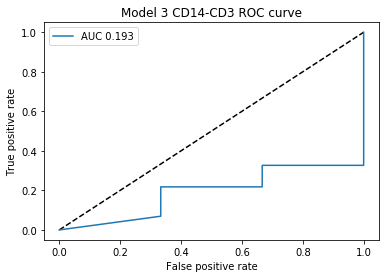

In [181]:
C = plt.figure(3)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr2_rf, tpr2_rf, label='AUC {:.3f}'.format(auc2_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model 3 CD14-CD3 ROC curve')
plt.legend(loc='best')
plt.show()





In [182]:
# CD 11-CD 14 model
X3 = matrix.iloc[:,24:1283].values
Y3 = matrix.iloc[:,1286:1287]
result3 = []
for i in Y3['CD14-CD11C']:
    if i > 1.5:
        result3.append("A")
    else:
        result3.append("B")

print(len(result3))
Y3.insert(loc=1, column='Label', value=result3)
Y3 = Y3["Label"].values
encoder.fit(Y3)
encoded_Y3 = encoder.transform(Y3)
encoded_Y3.shape
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, encoded_Y3, test_size = 0.2)
import numpy.ma as ma

X3_train = np.where(np.isnan(X3_train), ma.array(X3_train, mask=np.isnan(X3_train)).mean(axis=0), X3_train)
X3_test = np.where(np.isnan(X3_test), ma.array(X3_test, mask=np.isnan(X3_test)).mean(axis=0), X3_test)
model3 = Sequential()
model3.add(Dense(100, activation='relu'))
model3.add(Dense(60, activation='relu'))
model3.add(Dense(80, activation='relu'))
model3.add(Dense(60, activation='relu'))
model3.add(Dense(70, activation='relu'))
model3.add(Dense(1, activation ='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model3.fit(X3_train, y3_train, epochs=200, batch_size = 20)
y3_pred = model3.predict(X3_test).ravel()
fpr3_keras, tpr3_keras, thresholds3_keras = roc_curve(y3_test, y3_pred)
auc3_keras = auc(fpr3_keras, tpr3_keras)
rf3 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf3.fit(X3_train, y3_train)
y3_pred_rf = rf3.predict_proba(X3_test)[:, 1]
fpr3_rf, tpr3_rf, thresholds3_rf = roc_curve(y3_test, y3_pred)
auc3_rf = auc(fpr3_rf, tpr3_rf)

516
Epoch 1/200
412/412 [==============================] - 0s 955us/sample - loss: 58.3951 - acc: 0.8544
Epoch 2/200
412/412 [==============================] - 0s 237us/sample - loss: 11.9795 - acc: 0.8519
Epoch 3/200
412/412 [==============================] - 0s 207us/sample - loss: 8.6008 - acc: 0.8495
Epoch 4/200
412/412 [==============================] - 0s 237us/sample - loss: 10.5238 - acc: 0.8641
Epoch 5/200
412/412 [==============================] - 0s 233us/sample - loss: 12.3061 - acc: 0.8908
Epoch 6/200
412/412 [==============================] - 0s 242us/sample - loss: 18.9502 - acc: 0.8155
Epoch 7/200
412/412 [==============================] - 0s 219us/sample - loss: 4.9929 - acc: 0.8762
Epoch 8/200
412/412 [==============================] - 0s 219us/sample - loss: 2.9167 - acc: 0.8301
Epoch 9/200
412/412 [==============================] - 0s 225us/sample - loss: 8.2753 - acc: 0.9005
Epoch 10/200
412/412 [==============================] - 0s 218us/sample - loss: 2.5909 - ac

412/412 [==============================] - 0s 227us/sample - loss: 0.2057 - acc: 0.9223
Epoch 83/200
412/412 [==============================] - 0s 193us/sample - loss: 0.1976 - acc: 0.9320
Epoch 84/200
412/412 [==============================] - 0s 372us/sample - loss: 0.2143 - acc: 0.9223
Epoch 85/200
412/412 [==============================] - 0s 195us/sample - loss: 0.1815 - acc: 0.9369
Epoch 86/200
412/412 [==============================] - 0s 189us/sample - loss: 0.2308 - acc: 0.9272
Epoch 87/200
412/412 [==============================] - 0s 192us/sample - loss: 0.1982 - acc: 0.9320
Epoch 88/200
412/412 [==============================] - 0s 191us/sample - loss: 0.3216 - acc: 0.9248
Epoch 89/200
412/412 [==============================] - 0s 195us/sample - loss: 0.5154 - acc: 0.9005
Epoch 90/200
412/412 [==============================] - 0s 196us/sample - loss: 0.3114 - acc: 0.9078
Epoch 91/200
412/412 [==============================] - 0s 196us/sample - loss: 0.2545 - acc: 0.9199
Epo

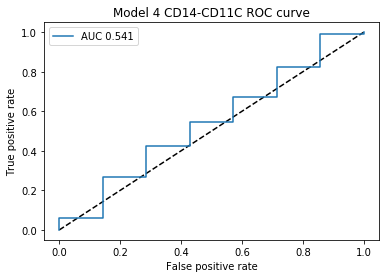

In [185]:

D = plt.figure(4)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr3_rf, tpr3_rf, label='AUC {:.3f}'.format(auc3_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model 4 CD14-CD11C ROC curve')
plt.legend(loc='best')
plt.show()

C.savefig("CD14-CD11C.pdf", bbox_inches='tight')

In [184]:
# CD 11-CD 14 model
X4 = matrix.iloc[:,25:1283].values
Y4 = matrix.iloc[:,1287:1288]
result4 = []
for i in Y4['CD14-CD14']:
    if i > 1.2:
        result4.append("A")
    else:
        result4.append("B")

print(len(result4))
Y4.insert(loc=1, column='Label', value=result4)
Y4 = Y4["Label"].values
encoder.fit(Y4)
encoded_Y4 = encoder.transform(Y4)
encoded_Y4.shape
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, encoded_Y4, test_size = 0.2)
import numpy.ma as ma

X4_train = np.where(np.isnan(X4_train), ma.array(X4_train, mask=np.isnan(X4_train)).mean(axis=0), X4_train)
X4_test = np.where(np.isnan(X4_test), ma.array(X4_test, mask=np.isnan(X4_test)).mean(axis=0), X4_test)
model4 = Sequential()
model4.add(Dense(100, activation='relu'))
model4.add(Dense(60, activation='relu'))
model4.add(Dense(80, activation='relu'))
model4.add(Dense(60, activation='relu'))
model4.add(Dense(70, activation='relu'))
model4.add(Dense(1, activation ='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model4.fit(X4_train, y4_train, epochs=200, batch_size = 20)
y4_pred = model4.predict(X4_test).ravel()
fpr4_keras, tpr4_keras, thresholds4_keras = roc_curve(y4_test, y4_pred)
auc4_keras = auc(fpr4_keras, tpr4_keras)
rf4 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf4.fit(X4_train, y4_train)
y4_pred_rf = rf4.predict_proba(X4_test)[:, 1]
fpr4_rf, tpr4_rf, thresholds4_rf = roc_curve(y4_test, y4_pred_rf)
auc4_rf = auc(fpr4_rf, tpr4_rf)

516
Epoch 1/200
412/412 [==============================] - 0s 1ms/sample - loss: 62.3161 - acc: 0.8398
Epoch 2/200
412/412 [==============================] - 0s 230us/sample - loss: 8.7272 - acc: 0.8592
Epoch 3/200
412/412 [==============================] - 0s 225us/sample - loss: 4.9379 - acc: 0.8447
Epoch 4/200
412/412 [==============================] - 0s 226us/sample - loss: 4.1280 - acc: 0.8325
Epoch 5/200
412/412 [==============================] - 0s 229us/sample - loss: 9.2867 - acc: 0.8180
Epoch 6/200
412/412 [==============================] - 0s 227us/sample - loss: 8.1444 - acc: 0.8665
Epoch 7/200
412/412 [==============================] - 0s 246us/sample - loss: 7.8494 - acc: 0.8641
Epoch 8/200
412/412 [==============================] - 0s 225us/sample - loss: 7.0940 - acc: 0.8277
Epoch 9/200
412/412 [==============================] - 0s 219us/sample - loss: 3.5414 - acc: 0.8641
Epoch 10/200
412/412 [==============================] - 0s 242us/sample - loss: 2.6140 - acc: 0.8

412/412 [==============================] - 0s 214us/sample - loss: 0.2685 - acc: 0.9126
Epoch 163/200
412/412 [==============================] - 0s 199us/sample - loss: 0.2530 - acc: 0.9223
Epoch 164/200
412/412 [==============================] - 0s 205us/sample - loss: 0.2548 - acc: 0.9029
Epoch 165/200
412/412 [==============================] - 0s 203us/sample - loss: 0.2461 - acc: 0.9175
Epoch 166/200
412/412 [==============================] - 0s 196us/sample - loss: 0.2288 - acc: 0.9175
Epoch 167/200
412/412 [==============================] - 0s 208us/sample - loss: 0.2453 - acc: 0.9102
Epoch 168/200
412/412 [==============================] - 0s 200us/sample - loss: 0.2302 - acc: 0.9199
Epoch 169/200
412/412 [==============================] - 0s 208us/sample - loss: 0.2756 - acc: 0.9175
Epoch 170/200
412/412 [==============================] - 0s 198us/sample - loss: 0.2850 - acc: 0.8956
Epoch 171/200
412/412 [==============================] - 0s 211us/sample - loss: 0.2825 - acc: 0

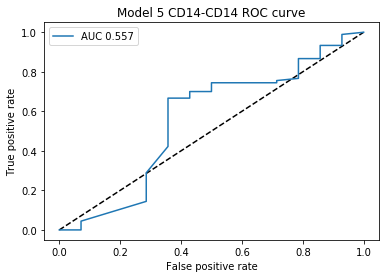

In [186]:
E = plt.figure(5)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr4_rf, tpr4_rf, label='AUC {:.3f}'.format(auc4_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model 5 CD14-CD14 ROC curve')
plt.legend(loc='best')
plt.show()

E.savefig("CD14-CD14.pdf", bbox_inches='tight')

NameError: name 'fpr5_rf' is not defined

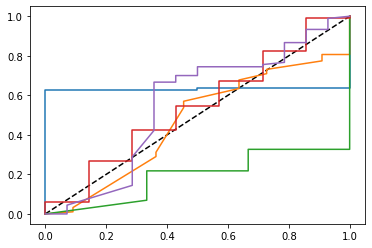

In [187]:
Z = plt.figure(20)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'Model 1 AUC {:.3f}'.format(auc_rf))
plt.plot(fpr1_rf, tpr1_rf, label = 'Model 2 AUC {:.3f}'.format(auc1_rf))
plt.plot(fpr2_rf, tpr2_rf, label= 'Model 3 AUC {:.3f}'.format(auc2_rf))
plt.plot(fpr3_rf, tpr3_rf, label= 'Model 4 AUC {:.3f}'.format(auc3_rf))
plt.plot(fpr4_rf, tpr4_rf, label='Model 5 AUC {:.3f}'.format(auc4_rf))
plt.plot(fpr5_rf, tpr5_rf, label = 'Model 6 AUC {:.3f}'.format(auc5_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve and AUC for First 6 Models')
plt.legend(loc='best')
plt.show()

Z.savefig("two.pdf", bbox_inches='tight')

In [188]:
# CD 11-CD 14 model
X5 = matrix.iloc[:,25:1283].values
Y5 = matrix.iloc[:,1288:1289]
result5 = []
for i in Y5['CD14-CD19']:
    if i > 1.2:
        result5.append("A")
    else:
        result5.append("B")

print(len(result5))
Y5.insert(loc=1, column='Label', value=result5)
Y5 = Y5["Label"].values
encoder.fit(Y5)
encoded_Y5 = encoder.transform(Y5)
encoded_Y5.shape
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, encoded_Y5, test_size = 0.2)
import numpy.ma as ma

X5_train = np.where(np.isnan(X5_train), ma.array(X5_train, mask=np.isnan(X5_train)).mean(axis=0), X5_train)
X5_test = np.where(np.isnan(X5_test), ma.array(X5_test, mask=np.isnan(X5_test)).mean(axis=0), X5_test)
model5 = Sequential()
model5.add(Dense(100, activation='relu'))
model5.add(Dense(60, activation='relu'))
model5.add(Dense(80, activation='relu'))
model5.add(Dense(60, activation='relu'))
model5.add(Dense(70, activation='relu'))
model5.add(Dense(1, activation ='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model5.fit(X5_train, y5_train, epochs=200, batch_size = 20)

rf5 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf5.fit(X5_train, y5_train)
y5_pred_rf = rf5.predict_proba(X5_test)[:, 1]
fpr5_rf, tpr5_rf, thresholds5_rf = roc_curve(y5_test, y5_pred_rf)
auc5_rf = auc(fpr5_rf, tpr5_rf)

516
Epoch 1/200
412/412 [==============================] - 0s 1ms/sample - loss: 49.3736 - acc: 0.7063
Epoch 2/200
412/412 [==============================] - 0s 288us/sample - loss: 18.1248 - acc: 0.7718
Epoch 3/200
412/412 [==============================] - 0s 241us/sample - loss: 22.9051 - acc: 0.7209
Epoch 4/200
412/412 [==============================] - 0s 242us/sample - loss: 5.8213 - acc: 0.7573
Epoch 5/200
412/412 [==============================] - 0s 210us/sample - loss: 5.2228 - acc: 0.7160
Epoch 6/200
412/412 [==============================] - 0s 232us/sample - loss: 3.2186 - acc: 0.7840
Epoch 7/200
412/412 [==============================] - 0s 222us/sample - loss: 3.8242 - acc: 0.7379
Epoch 8/200
412/412 [==============================] - 0s 260us/sample - loss: 1.9660 - acc: 0.8107
Epoch 9/200
412/412 [==============================] - 0s 272us/sample - loss: 4.0060 - acc: 0.7597
Epoch 10/200
412/412 [==============================] - 0s 273us/sample - loss: 5.2092 - acc: 0

412/412 [==============================] - 0s 204us/sample - loss: 0.3850 - acc: 0.8447
Epoch 163/200
412/412 [==============================] - 0s 195us/sample - loss: 0.3701 - acc: 0.8471
Epoch 164/200
412/412 [==============================] - 0s 198us/sample - loss: 0.3414 - acc: 0.8592
Epoch 165/200
412/412 [==============================] - 0s 202us/sample - loss: 0.3932 - acc: 0.8447
Epoch 166/200
412/412 [==============================] - 0s 204us/sample - loss: 0.3660 - acc: 0.8568
Epoch 167/200
412/412 [==============================] - 0s 207us/sample - loss: 0.4150 - acc: 0.8422
Epoch 168/200
412/412 [==============================] - 0s 194us/sample - loss: 0.3428 - acc: 0.8689
Epoch 169/200
412/412 [==============================] - 0s 206us/sample - loss: 0.3370 - acc: 0.8617
Epoch 170/200
412/412 [==============================] - 0s 205us/sample - loss: 0.3496 - acc: 0.8592
Epoch 171/200
412/412 [==============================] - 0s 188us/sample - loss: 0.3246 - acc: 0

In [448]:
# CD 19-CD 14 model
X6 = matrix.iloc[:,25:1283].values
Y6 = matrix.iloc[:,1289:1290]
result6 = []
for i in Y6['CD19-CD14']:
    if i > 1.2:
        result6.append("A")
    else:
        result6.append("B")

print(len(result6))
Y6.insert(loc=1, column='Label', value=result6)
Y6 = Y6["Label"].values
encoder.fit(Y6)
encoded_Y6 = encoder.transform(Y6)
encoded_Y6.shape
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, encoded_Y6, test_size = 0.2)
import numpy.ma as ma

X6_train = np.where(np.isnan(X6_train), ma.array(X6_train, mask=np.isnan(X6_train)).mean(axis=0), X6_train)
X6_test = np.where(np.isnan(X6_test), ma.array(X6_test, mask=np.isnan(X6_test)).mean(axis=0), X6_test)
model6 = Sequential()
model6.add(Dense(100, activation='relu'))
model6.add(Dense(60, activation='relu'))
model6.add(Dense(80, activation='relu'))
model6.add(Dense(60, activation='relu'))
model6.add(Dense(70, activation='relu'))
model6.add(Dense(1, activation ='sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model6.fit(X6_train, y6_train, epochs=200, batch_size = 20)

rf6 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf6.fit(X6_train, y6_train)
y6_pred_rf = rf6.predict_proba(X6_test)[:, 1]
fpr6_rf, tpr6_rf, thresholds6_rf = roc_curve(y6_test, y6_pred_rf)
auc6_rf = auc(fpr6_rf, tpr6_rf)

516
Epoch 1/200
412/412 [==============================] - 1s 2ms/sample - loss: 67778.0154 - acc: 0.7136
Epoch 2/200
412/412 [==============================] - 0s 290us/sample - loss: 13.5709 - acc: 0.7257
Epoch 3/200
412/412 [==============================] - 0s 329us/sample - loss: 13.8915 - acc: 0.7500
Epoch 4/200
412/412 [==============================] - 0s 328us/sample - loss: 8.9914 - acc: 0.7087
Epoch 5/200
412/412 [==============================] - 0s 314us/sample - loss: 5.6458 - acc: 0.7160
Epoch 6/200
412/412 [==============================] - 0s 281us/sample - loss: 6.4153 - acc: 0.7354
Epoch 7/200
412/412 [==============================] - 0s 294us/sample - loss: 8.0547 - acc: 0.7015
Epoch 8/200
412/412 [==============================] - 0s 288us/sample - loss: 4.9388 - acc: 0.7233
Epoch 9/200
412/412 [==============================] - 0s 277us/sample - loss: 4.7607 - acc: 0.7476
Epoch 10/200
412/412 [==============================] - 0s 286us/sample - loss: 7.6688 - acc

412/412 [==============================] - 0s 398us/sample - loss: 0.7207 - acc: 0.7961
Epoch 83/200
412/412 [==============================] - 0s 413us/sample - loss: 0.8897 - acc: 0.7888
Epoch 84/200
412/412 [==============================] - 0s 484us/sample - loss: 0.5761 - acc: 0.7961
Epoch 85/200
412/412 [==============================] - 0s 402us/sample - loss: 0.5737 - acc: 0.7718
Epoch 86/200
412/412 [==============================] - 0s 450us/sample - loss: 0.8199 - acc: 0.7718
Epoch 87/200
412/412 [==============================] - 0s 431us/sample - loss: 0.6562 - acc: 0.7743
Epoch 88/200
412/412 [==============================] - 0s 400us/sample - loss: 0.8033 - acc: 0.7694
Epoch 89/200
412/412 [==============================] - 0s 361us/sample - loss: 0.4994 - acc: 0.8325
Epoch 90/200
412/412 [==============================] - 0s 318us/sample - loss: 0.4738 - acc: 0.8107
Epoch 91/200
412/412 [==============================] - 0s 331us/sample - loss: 0.5222 - acc: 0.7937
Epo

In [458]:
# CD 19-CD 19 model
X7 = matrix.iloc[:,25:1283].values
Y7 = matrix.iloc[:,1290:1291]
result7 = []
for i in Y7['CD19-CD19']:
    if i > 1.2:
        result7.append("A")
    else:
        result7.append("B")

print(len(result6))
Y7.insert(loc=1, column='Label', value=result7)
Y7 = Y7["Label"].values
encoder.fit(Y7)
encoded_Y7 = encoder.transform(Y7)
encoded_Y7.shape
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, encoded_Y7, test_size = 0.2)
import numpy.ma as ma

X7_train = np.where(np.isnan(X7_train), ma.array(X7_train, mask=np.isnan(X7_train)).mean(axis=0), X7_train)
X7_test = np.where(np.isnan(X7_test), ma.array(X7_test, mask=np.isnan(X7_test)).mean(axis=0), X7_test)
model7 = Sequential()
model7.add(Dense(100, activation='relu'))
model7.add(Dense(60, activation='relu'))
model7.add(Dense(80, activation='relu'))
model7.add(Dense(60, activation='relu'))
model7.add(Dense(70, activation='relu'))
model7.add(Dense(1, activation ='sigmoid'))
model7.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model7.fit(X7_train, y7_train, epochs=200, batch_size = 20)

rf7 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf7.fit(X7_train, y7_train)
y7_pred_rf = rf7.predict_proba(X7_test)[:, 1]
fpr7_rf, tpr7_rf, thresholds7_rf = roc_curve(y7_test, y7_pred_rf)
auc7_rf = auc(fpr7_rf, tpr7_rf)

516
Epoch 1/200
412/412 [==============================] - 1s 3ms/sample - loss: 35.2786 - acc: 0.7379
Epoch 2/200
412/412 [==============================] - 0s 490us/sample - loss: 20.0330 - acc: 0.8252
Epoch 3/200
412/412 [==============================] - 0s 359us/sample - loss: 3.3749 - acc: 0.8155
Epoch 4/200
412/412 [==============================] - 0s 318us/sample - loss: 5.4804 - acc: 0.7864
Epoch 5/200
412/412 [==============================] - 0s 329us/sample - loss: 6.3537 - acc: 0.8010
Epoch 6/200
412/412 [==============================] - 0s 462us/sample - loss: 6.8050 - acc: 0.8155
Epoch 7/200
412/412 [==============================] - 0s 417us/sample - loss: 4.3513 - acc: 0.7888
Epoch 8/200
412/412 [==============================] - 0s 484us/sample - loss: 2.9116 - acc: 0.8422
Epoch 9/200
412/412 [==============================] - 0s 451us/sample - loss: 2.6131 - acc: 0.7864
Epoch 10/200
412/412 [==============================] - 0s 368us/sample - loss: 1.9538 - acc: 0.

412/412 [==============================] - 0s 277us/sample - loss: 25.9511 - acc: 0.8180
Epoch 163/200
412/412 [==============================] - 0s 277us/sample - loss: 6.7133 - acc: 0.7985
Epoch 164/200
412/412 [==============================] - 0s 280us/sample - loss: 2.5540 - acc: 0.8277
Epoch 165/200
412/412 [==============================] - 0s 280us/sample - loss: 3.3149 - acc: 0.7937
Epoch 166/200
412/412 [==============================] - 0s 289us/sample - loss: 0.8072 - acc: 0.7864
Epoch 167/200
412/412 [==============================] - 0s 280us/sample - loss: 0.7577 - acc: 0.8252
Epoch 168/200
412/412 [==============================] - 0s 279us/sample - loss: 0.3735 - acc: 0.8786
Epoch 169/200
412/412 [==============================] - 0s 290us/sample - loss: 0.3655 - acc: 0.8859
Epoch 170/200
412/412 [==============================] - 0s 282us/sample - loss: 0.3954 - acc: 0.8908
Epoch 171/200
412/412 [==============================] - 0s 274us/sample - loss: 0.3779 - acc: 

In [460]:
# CD 19-CD3 model
X8 = matrix.iloc[:,25:1283].values
Y8 = matrix.iloc[:,1291:1292]
result8 = []
for i in Y8['CD19-CD3']:
    if i > 1.2:
        result8.append("A")
    else:
        result8.append("B")

print(len(result8))
Y8.insert(loc=1, column='Label', value=result8)
Y8 = Y8["Label"].values
encoder.fit(Y8)
encoded_Y8 = encoder.transform(Y8)
encoded_Y8.shape
X8_train, X8_test, y8_train, y8_test = train_test_split(X8, encoded_Y8, test_size = 0.2)
import numpy.ma as ma

X8_train = np.where(np.isnan(X8_train), ma.array(X8_train, mask=np.isnan(X8_train)).mean(axis=0), X8_train)
X8_test = np.where(np.isnan(X8_test), ma.array(X8_test, mask=np.isnan(X8_test)).mean(axis=0), X8_test)
model8 = Sequential()
model8.add(Dense(100, activation='relu'))
model8.add(Dense(60, activation='relu'))
model8.add(Dense(80, activation='relu'))
model8.add(Dense(60, activation='relu'))
model8.add(Dense(70, activation='relu'))
model8.add(Dense(1, activation ='sigmoid'))
model8.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model8.fit(X8_train, y8_train, epochs=200, batch_size = 20)

rf8 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf8.fit(X8_train, y8_train)
y8_pred_rf = rf8.predict_proba(X8_test)[:, 1]
fpr8_rf, tpr8_rf, thresholds8_rf = roc_curve(y8_test, y8_pred_rf)
auc8_rf = auc(fpr8_rf, tpr8_rf)

516
Epoch 1/200
412/412 [==============================] - 1s 2ms/sample - loss: 45.3460 - acc: 0.7743
Epoch 2/200
412/412 [==============================] - 0s 328us/sample - loss: 14.6570 - acc: 0.8252
Epoch 3/200
412/412 [==============================] - 0s 314us/sample - loss: 11.6494 - acc: 0.8034
Epoch 4/200
412/412 [==============================] - 0s 313us/sample - loss: 4.5995 - acc: 0.7937
Epoch 5/200
412/412 [==============================] - 0s 310us/sample - loss: 4.4890 - acc: 0.8301
Epoch 6/200
412/412 [==============================] - 0s 312us/sample - loss: 8.3030 - acc: 0.7913
Epoch 7/200
412/412 [==============================] - 0s 331us/sample - loss: 3.3143 - acc: 0.8107
Epoch 8/200
412/412 [==============================] - 0s 316us/sample - loss: 2.8450 - acc: 0.8350
Epoch 9/200
412/412 [==============================] - 0s 313us/sample - loss: 6.7944 - acc: 0.8252
Epoch 10/200
412/412 [==============================] - 0s 310us/sample - loss: 2.8663 - acc: 0

412/412 [==============================] - 0s 336us/sample - loss: 0.3250 - acc: 0.8956
Epoch 163/200
412/412 [==============================] - 0s 323us/sample - loss: 0.3467 - acc: 0.8981
Epoch 164/200
412/412 [==============================] - 0s 338us/sample - loss: 0.3353 - acc: 0.8908
Epoch 165/200
412/412 [==============================] - 0s 396us/sample - loss: 0.3495 - acc: 0.8859
Epoch 166/200
412/412 [==============================] - 0s 381us/sample - loss: 0.3094 - acc: 0.8932
Epoch 167/200
412/412 [==============================] - 0s 324us/sample - loss: 0.3146 - acc: 0.8932
Epoch 168/200
412/412 [==============================] - 0s 382us/sample - loss: 0.3325 - acc: 0.8932
Epoch 169/200
412/412 [==============================] - 0s 350us/sample - loss: 0.4164 - acc: 0.8835
Epoch 170/200
412/412 [==============================] - 0s 312us/sample - loss: 0.3574 - acc: 0.8908
Epoch 171/200
412/412 [==============================] - 0s 330us/sample - loss: 0.3209 - acc: 0

In [465]:
# CD3-CD11C model
X9 = matrix.iloc[:,25:1283].values
Y9 = matrix.iloc[:,1292:1293]
result9 = []
for i in Y9['CD3-CD11C']:
    if i > 1.2:
        result9.append("A")
    else:
        result9.append("B")

print(len(result9))
Y9.insert(loc=1, column='Label', value=result9)
Y9 = Y9["Label"].values
encoder.fit(Y9)
encoded_Y9 = encoder.transform(Y9)
encoded_Y9.shape
X9_train, X9_test, y9_train, y9_test = train_test_split(X9, encoded_Y9, test_size = 0.2)
import numpy.ma as ma

X9_train = np.where(np.isnan(X9_train), ma.array(X9_train, mask=np.isnan(X9_train)).mean(axis=0), X9_train)
X9_test = np.where(np.isnan(X9_test), ma.array(X9_test, mask=np.isnan(X9_test)).mean(axis=0), X9_test)
model9 = Sequential()
model9.add(Dense(100, activation='relu'))
model9.add(Dense(60, activation='relu'))
model9.add(Dense(80, activation='relu'))
model9.add(Dense(60, activation='relu'))
model9.add(Dense(70, activation='relu'))
model9.add(Dense(1, activation ='sigmoid'))
model9.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model9.fit(X9_train, y9_train, epochs=200, batch_size = 20)

rf9 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf9.fit(X9_train, y9_train)
y9_pred_rf = rf9.predict_proba(X9_test)[:, 1]
fpr9_rf, tpr9_rf, thresholds9_rf = roc_curve(y9_test, y9_pred_rf)
auc9_rf = auc(fpr9_rf, tpr9_rf)


516
Epoch 1/200
412/412 [==============================] - 1s 3ms/sample - loss: 37.3404 - acc: 0.7767
Epoch 2/200
412/412 [==============================] - 0s 554us/sample - loss: 9.4115 - acc: 0.8325
Epoch 3/200
412/412 [==============================] - 0s 385us/sample - loss: 11.4683 - acc: 0.7718
Epoch 4/200
412/412 [==============================] - 0s 374us/sample - loss: 9.3938 - acc: 0.8277
Epoch 5/200
412/412 [==============================] - 0s 358us/sample - loss: 9.5572 - acc: 0.7864
Epoch 6/200
412/412 [==============================] - 0s 482us/sample - loss: 6.7316 - acc: 0.8180
Epoch 7/200
412/412 [==============================] - 0s 342us/sample - loss: 4.7760 - acc: 0.8180
Epoch 8/200
412/412 [==============================] - 0s 352us/sample - loss: 3.6030 - acc: 0.7985
Epoch 9/200
412/412 [==============================] - 0s 363us/sample - loss: 2.1933 - acc: 0.8325
Epoch 10/200
412/412 [==============================] - 0s 373us/sample - loss: 3.0623 - acc: 0.

412/412 [==============================] - 0s 339us/sample - loss: 0.3178 - acc: 0.8835
Epoch 162/200
412/412 [==============================] - 0s 312us/sample - loss: 0.3301 - acc: 0.8835
Epoch 163/200
412/412 [==============================] - 0s 280us/sample - loss: 0.3201 - acc: 0.8835
Epoch 164/200
412/412 [==============================] - 0s 290us/sample - loss: 0.3032 - acc: 0.8835
Epoch 165/200
412/412 [==============================] - 0s 287us/sample - loss: 0.3619 - acc: 0.8835
Epoch 166/200
412/412 [==============================] - 0s 300us/sample - loss: 0.3879 - acc: 0.8835
Epoch 167/200
412/412 [==============================] - 0s 325us/sample - loss: 0.3580 - acc: 0.8835
Epoch 168/200
412/412 [==============================] - 0s 276us/sample - loss: 0.3310 - acc: 0.8835
Epoch 169/200
412/412 [==============================] - 0s 275us/sample - loss: 0.3171 - acc: 0.8835
Epoch 170/200
412/412 [==============================] - 0s 279us/sample - loss: 0.3265 - acc: 0

In [466]:
# CD3-CD19 model
X10 = matrix.iloc[:,25:1283].values
Y10 = matrix.iloc[:,1293:1294]
result10 = []
for i in Y10['CD3-CD19']:
    if i > 1.2:
        result10.append("A")
    else:
        result10.append("B")

print(len(result10))
Y10.insert(loc=1, column='Label', value=result10)
Y10 = Y10["Label"].values
encoder.fit(Y10)
encoded_Y10 = encoder.transform(Y10)
encoded_Y10.shape
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, encoded_Y10, test_size = 0.2)
import numpy.ma as ma

X10_train = np.where(np.isnan(X10_train), ma.array(X10_train, mask=np.isnan(X10_train)).mean(axis=0), X10_train)
X10_test = np.where(np.isnan(X10_test), ma.array(X10_test, mask=np.isnan(X10_test)).mean(axis=0), X10_test)
model10 = Sequential()
model10.add(Dense(100, activation='relu'))
model10.add(Dense(60, activation='relu'))
model10.add(Dense(80, activation='relu'))
model10.add(Dense(60, activation='relu'))
model10.add(Dense(70, activation='relu'))
model10.add(Dense(1, activation ='sigmoid'))
model10.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model10.fit(X10_train, y10_train, epochs=200, batch_size = 20)

rf10 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf10.fit(X10_train, y10_train)
y10_pred_rf = rf10.predict_proba(X10_test)[:, 1]
fpr10_rf, tpr10_rf, thresholds10_rf = roc_curve(y10_test, y10_pred_rf)
auc10_rf = auc(fpr10_rf, tpr10_rf)



516
Epoch 1/200
412/412 [==============================] - 1s 2ms/sample - loss: 33660.5151 - acc: 0.8422
Epoch 2/200
412/412 [==============================] - 0s 318us/sample - loss: 13.3070 - acc: 0.8350
Epoch 3/200
412/412 [==============================] - 0s 325us/sample - loss: 16.4242 - acc: 0.8325
Epoch 4/200
412/412 [==============================] - 0s 313us/sample - loss: 12.7548 - acc: 0.8447
Epoch 5/200
412/412 [==============================] - 0s 345us/sample - loss: 10.8951 - acc: 0.8398
Epoch 6/200
412/412 [==============================] - 0s 302us/sample - loss: 2.7286 - acc: 0.8738
Epoch 7/200
412/412 [==============================] - 0s 295us/sample - loss: 4.1363 - acc: 0.8350
Epoch 8/200
412/412 [==============================] - 0s 328us/sample - loss: 3.2360 - acc: 0.8617
Epoch 9/200
412/412 [==============================] - 0s 301us/sample - loss: 3.8569 - acc: 0.8568
Epoch 10/200
412/412 [==============================] - 0s 309us/sample - loss: 6.3351 - a

412/412 [==============================] - 0s 291us/sample - loss: 0.2659 - acc: 0.9199
Epoch 162/200
412/412 [==============================] - 0s 288us/sample - loss: 0.2545 - acc: 0.9199
Epoch 163/200
412/412 [==============================] - 0s 293us/sample - loss: 0.2397 - acc: 0.9126
Epoch 164/200
412/412 [==============================] - 0s 288us/sample - loss: 0.2465 - acc: 0.9248
Epoch 165/200
412/412 [==============================] - 0s 357us/sample - loss: 0.2388 - acc: 0.9150
Epoch 166/200
412/412 [==============================] - 0s 294us/sample - loss: 0.2238 - acc: 0.9223
Epoch 167/200
412/412 [==============================] - 0s 323us/sample - loss: 0.2540 - acc: 0.9199
Epoch 168/200
412/412 [==============================] - 0s 343us/sample - loss: 0.2287 - acc: 0.9199
Epoch 169/200
412/412 [==============================] - 0s 358us/sample - loss: 0.2151 - acc: 0.9248
Epoch 170/200
412/412 [==============================] - 0s 347us/sample - loss: 0.2252 - acc: 0

In [467]:
# CD3-CD3 model
X11 = matrix.iloc[:,25:1283].values
Y11 = matrix.iloc[:,1294:1295]
result11 = []
for i in Y11['CD3-CD3']:
    if i > 1.2:
        result11.append("A")
    else:
        result11.append("B")

print(len(result11))
Y11.insert(loc=1, column='Label', value=result11)
Y11 = Y11["Label"].values
encoder.fit(Y11)
encoded_Y11 = encoder.transform(Y11)
encoded_Y11.shape
X11_train, X11_test, y11_train, y11_test = train_test_split(X11, encoded_Y11, test_size = 0.2)
import numpy.ma as ma

X11_train = np.where(np.isnan(X11_train), ma.array(X11_train, mask=np.isnan(X11_train)).mean(axis=0), X11_train)
X11_test = np.where(np.isnan(X11_test), ma.array(X11_test, mask=np.isnan(X11_test)).mean(axis=0), X11_test)
model11 = Sequential()
model11.add(Dense(100, activation='relu'))
model11.add(Dense(60, activation='relu'))
model11.add(Dense(80, activation='relu'))
model11.add(Dense(60, activation='relu'))
model11.add(Dense(70, activation='relu'))
model11.add(Dense(1, activation ='sigmoid'))
model11.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model11.fit(X11_train, y11_train, epochs=200, batch_size = 20)

rf11 = RandomForestClassifier(max_depth=3, n_estimators=15)
rf11.fit(X11_train, y11_train)
y11_pred_rf = rf11.predict_proba(X11_test)[:, 1]
fpr11_rf, tpr11_rf, thresholds11_rf = roc_curve(y11_test, y11_pred_rf)
auc11_rf = auc(fpr11_rf, tpr11_rf)




516
Epoch 1/200
412/412 [==============================] - 1s 3ms/sample - loss: 2778643.2058 - acc: 0.7476
Epoch 2/200
412/412 [==============================] - 0s 325us/sample - loss: 19.1165 - acc: 0.8107
Epoch 3/200
412/412 [==============================] - 0s 505us/sample - loss: 8.2727 - acc: 0.7743
Epoch 4/200
412/412 [==============================] - 0s 364us/sample - loss: 18.1163 - acc: 0.8422
Epoch 5/200
412/412 [==============================] - 0s 350us/sample - loss: 6.5448 - acc: 0.7840
Epoch 6/200
412/412 [==============================] - 0s 476us/sample - loss: 9.6563 - acc: 0.7840
Epoch 7/200
412/412 [==============================] - 0s 309us/sample - loss: 6.0745 - acc: 0.7913
Epoch 8/200
412/412 [==============================] - 0s 315us/sample - loss: 3.0385 - acc: 0.8058
Epoch 9/200
412/412 [==============================] - 0s 307us/sample - loss: 6.9496 - acc: 0.7961
Epoch 10/200
412/412 [==============================] - 0s 310us/sample - loss: 7.1592 - a

412/412 [==============================] - 0s 326us/sample - loss: 0.3400 - acc: 0.9005
Epoch 162/200
412/412 [==============================] - 0s 326us/sample - loss: 0.3530 - acc: 0.8908
Epoch 163/200
412/412 [==============================] - 0s 291us/sample - loss: 0.3046 - acc: 0.9005
Epoch 164/200
412/412 [==============================] - 0s 305us/sample - loss: 0.3502 - acc: 0.9029
Epoch 165/200
412/412 [==============================] - 0s 316us/sample - loss: 0.3116 - acc: 0.8956
Epoch 166/200
412/412 [==============================] - 0s 326us/sample - loss: 0.5486 - acc: 0.8350
Epoch 167/200
412/412 [==============================] - 0s 313us/sample - loss: 0.6867 - acc: 0.8447
Epoch 168/200
412/412 [==============================] - 0s 296us/sample - loss: 0.5047 - acc: 0.8883
Epoch 169/200
412/412 [==============================] - 0s 354us/sample - loss: 0.4600 - acc: 0.8665
Epoch 170/200
412/412 [==============================] - 0s 311us/sample - loss: 0.6932 - acc: 0

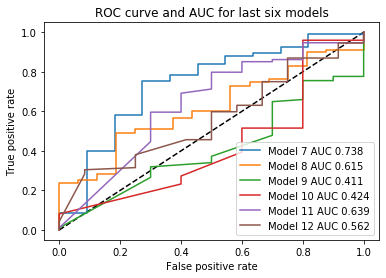

In [468]:
Y = plt.figure(19)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr6_rf, tpr6_rf, label = 'Model 7 AUC {:.3f}'.format(auc6_rf))
plt.plot(fpr7_rf, tpr7_rf, label = 'Model 8 AUC {:.3f}'.format(auc7_rf))
plt.plot(fpr8_rf, tpr8_rf, label = 'Model 9 AUC {:.3f}'.format(auc8_rf))
plt.plot(fpr9_rf, tpr9_rf, label = 'Model 10 AUC {:.3f}'.format(auc9_rf))
plt.plot(fpr10_rf, tpr10_rf, label = 'Model 11 AUC {:.3f}'.format(auc10_rf))
plt.plot(fpr11_rf, tpr11_rf, label = 'Model 12 AUC {:.3f}'.format(auc11_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve and AUC for last six models')
plt.legend(loc='best')
plt.show()

Y.savefig("three.pdf", bbox_inches='tight')

In [469]:
_, accuracy = model.evaluate(X_test,y_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model1.evaluate(X1_test,y1_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model2.evaluate(X2_test,y2_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model3.evaluate(X3_test,y3_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model4.evaluate(X4_test,y4_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model5.evaluate(X5_test,y5_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model6.evaluate(X6_test,y6_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model7.evaluate(X7_test,y7_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model8.evaluate(X8_test,y8_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model9.evaluate(X9_test,y9_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model10.evaluate(X10_test,y10_test)
print('Accuracy: %.2f' % (accuracy*100))
_, accuracy = model11.evaluate(X11_test,y11_test)
print('Accuracy: %.2f' % (accuracy*100))



104/104 [==============================] - 0s 323us/sample - loss: 0.5423 - acc: 0.8654
Accuracy: 86.54
104/104 [==============================] - 1s 8ms/sample - loss: 1.3094 - acc: 0.7885
Accuracy: 78.85
104/104 [==============================] - 1s 6ms/sample - loss: 0.3931 - acc: 0.8654
Accuracy: 86.54
104/104 [==============================] - 1s 6ms/sample - loss: 0.5847 - acc: 0.8750
Accuracy: 87.50
104/104 [==============================] - 1s 6ms/sample - loss: 1951355.4153 - acc: 0.9038
Accuracy: 90.38
104/104 [==============================] - 1s 6ms/sample - loss: 0.5700 - acc: 0.8365
Accuracy: 83.65
104/104 [==============================] - 1s 6ms/sample - loss: 0.6371 - acc: 0.8558
Accuracy: 85.58
104/104 [==============================] - 1s 6ms/sample - loss: 1.0685 - acc: 0.8462
Accuracy: 84.62
104/104 [==============================] - 1s 6ms/sample - loss: 0.3612 - acc: 0.9038
Accuracy: 90.38
104/104 [==============================] - 1s 6ms/sample - loss: 0.5693 - 

NameError: name 'model12' is not defined

In [217]:
print (doubles)

{1:      CD11C-CD14
0     -0.132812
1      0.817588
2     -0.111246
3     -2.945788
4      0.227102
..          ...
511   -1.410721
512    0.631269
513    2.333335
514    0.266119
515    1.216488

[516 rows x 1 columns], 2:      CD11C-CD3
0     0.397287
1    -1.765300
2     1.481154
3     2.876020
4    -0.182275
..         ...
511  -0.454895
512   1.046135
513   0.115015
514  -0.458079
515   0.014420

[516 rows x 1 columns], 3:      CD14-CD11C
0     -0.025038
1      0.609867
2     -0.113331
3     -2.325651
4     -0.985964
..          ...
511   -1.325443
512   -0.384382
513    2.311588
514    0.476730
515    0.518455

[516 rows x 1 columns], 4:      CD14-CD14
0    -0.793955
1     0.447237
2    -0.030185
3    -1.466094
4    -0.438482
..         ...
511  -0.441962
512   0.711120
513   1.873843
514   0.442019
515   1.417259

[516 rows x 1 columns], 5:      CD14-CD19
0    -0.643230
1    -1.337265
2    -0.907749
3    -0.094693
4    -0.509173
..         ...
511  -0.043978
512   0.221719
513  